# 3D Computer Vision - Exercise 3
Olivier Kanamugire

January 27, 2025.

## Task 1. Filtering with linear and median filters (1 point)

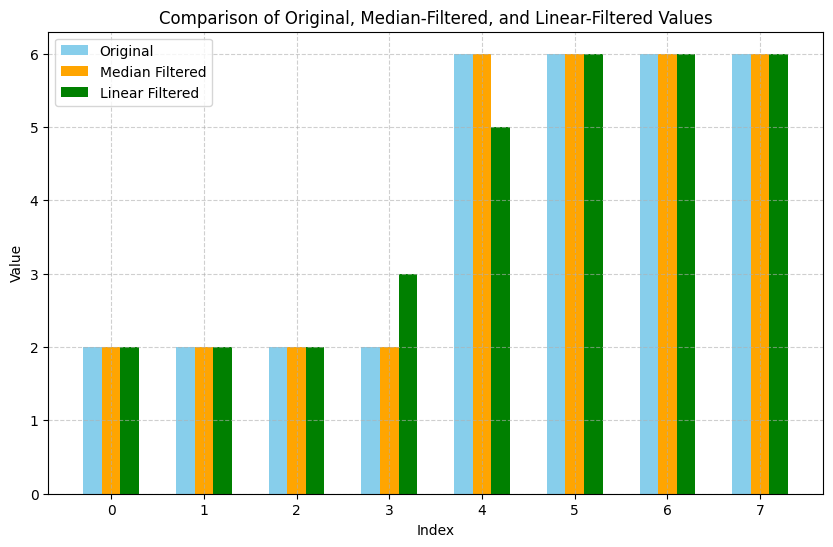

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define f(i) and m
def function(i):
    if i in range(4):
        return 2
    elif i in range(4, 8):
        return 6

m = 3
# Domain of the function
Dom_f = np.arange(8) 
# Range of the function 
f_values = np.array([function(i) for i in Dom_f])  # Range of the function

# Compute median filtered f(i) (including boundary elements)
median_filtered = np.zeros_like(f_values)
for i in range(len(f_values)):
    # Define a 3-element window with edge extension
    if i == 0:  # Left boundary
        window = np.array([f_values[0], f_values[0], f_values[1]])
    elif i == len(f_values) - 1:  # Right boundary
        window = np.array([f_values[-2], f_values[-1], f_values[-1]])
    else:
        window = f_values[i - 1:i + 2]
    median_filtered[i] = np.median(window)

# Define kernel and compute linear filtered f(i) (including boundary elements)
kernel = np.array([1 / 4, 1 / 2, 1 / 4])
linear_filtered = np.zeros_like(f_values, dtype=float)
for i in range(len(f_values)):
    # Define a 3-element window with edge extension
    if i == 0:  # Left boundary
        window = np.array([f_values[0], f_values[0], f_values[1]])
    elif i == len(f_values) - 1:  # Right boundary
        window = np.array([f_values[-2], f_values[-1], f_values[-1]])
    else:
        window = f_values[i - 1:i + 2]
    linear_filtered[i] = np.sum(window * kernel)

# Show results
x = np.arange(len(f_values))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, f_values, width=0.2, label='Original', align='center', color="skyblue")
plt.bar(x, median_filtered, width=0.2, label='Median Filtered', align='center', color="orange")
plt.bar(x + 0.2, linear_filtered, width=0.2, label='Linear Filtered', align='center', color="green")

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Original, Median-Filtered, and Linear-Filtered Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#### Discussion

* From the theory, we know that median filtering preserves boundaries while linear filtering does not.
* The boundaries are on $x = 3$ where $f =2$ and $x =4$ where $f =6$.
* From the graph, we can see for the median filter preserves sharp transitions (2 to 6), with values mostly unchanged while linear filtering produces a smoother transition between the steps due to averaging, effectively blurring the sharp edge.

* You can see the values from the graph after filtering.



## Task 2. Intrinsic calibration (1 point)
You can install the `cv2` package by running `pip3 install opencv-python` 

In [2]:
# pip install scikit-image


In [3]:
import cv2
from scipy.ndimage import gaussian_filter, median_filter
from skimage.metrics import peak_signal_noise_ratio as psnr

### Helper functions for displaying images

In [4]:
def show_image(img, title):
    """
    Displays an image with a given title.
    Parameters:
        img (ndarray): The image to be displayed.
        title (str): The title of the image.
    """

    plt.imshow(img, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title(title)
    plt.show()


def show_images(imgs: list[np.ndarray], titles: list[str], suptitle: str | None = None):
    """
    Display a list of images side by side with corresponding titles.
    Parameters:
        imgs (list[np.ndarray]): List of images to display. Each image should be a NumPy array.
        titles (list[str]): List of titles corresponding to each image.
        suptitle (str | None, optional): A super title for the entire figure. Defaults to None.
    """

    # calculate aspect ratio
    aspect = imgs[0].shape[1] / imgs[0].shape[0]

    # create figure and axes
    fig, axs = plt.subplots(1, len(imgs), figsize=(5 * len(imgs) * aspect, 5))
    for i, img in enumerate(imgs):
        axs[i].imshow(img, cmap="gray")
        axs[i].set_title(titles[i])
        axs[i].axis("off")

    if suptitle:
        fig.suptitle(suptitle)

    # show
    plt.tight_layout()
    plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\olivi\AppData\Local\Temp\ipykernel_11348\1036555002.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Lena Image with Gaussian Noise ($\sigma ^2 = 0.01$)")


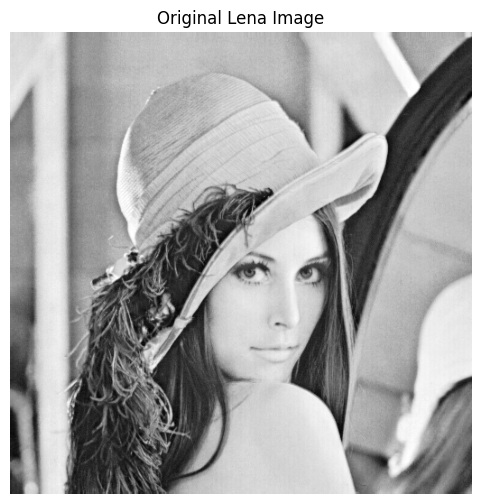

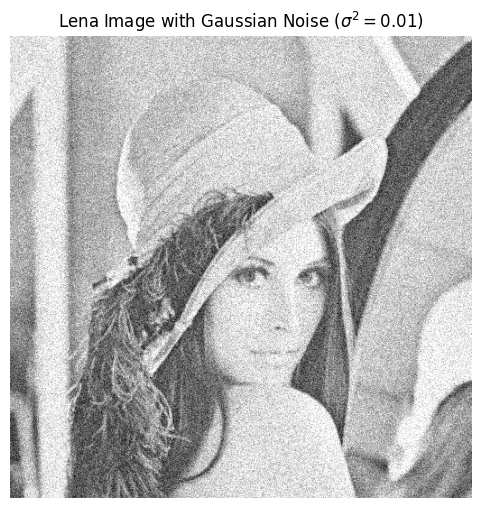

In [5]:
# load and normalize the image
image = cv2.imread("lena_bw.png", cv2.IMREAD_GRAYSCALE)
# Normalize pixel values to [0, 1]
image = image / 255.0  

# add Gaussian noise to the image
# Display the original image
plt.figure(figsize=(6, 6))
plt.title("Original Lena Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Add zero-mean Gaussian noise
sigma_noise = np.sqrt(0.01)
gaussian_noisy_image = image + np.random.normal(0, sigma_noise, image.shape)
gaussian_noisy_image = np.clip(gaussian_noisy_image, 0, 1)

# Display the noisy image
plt.figure(figsize=(6, 6))
plt.title("Lena Image with Gaussian Noise ($\sigma ^2 = 0.01$)")
plt.imshow(gaussian_noisy_image, cmap='gray')
plt.axis('off')
plt.show()



## Define the function for the applying filters

In [6]:
def apply_filters(image, sigma_values, median_sizes):
    results = {}
    # Gaussian filters
    for sigma in sigma_values:
        kernel_size = int(np.ceil(6 * sigma)) + 1
        kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1  # Ensure odd size
        gaussian_filtered = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmaX=sigma)
        results[f"Gaussian sigma={sigma} (kernel {kernel_size}x{kernel_size})"] = gaussian_filtered

    # Median filters
    for size in median_sizes:
        median_filtered = cv2.medianBlur((image * 255).astype(np.uint8), size)
        results[f"Median {size}x{size}"] = median_filtered / 255.0  # Normalize back to [0, 1]

    return results

In [7]:
# Parameters for filters

sigma_values = [0.5, 1, 2]
median_sizes = [3, 5, 9]

### a) Gaussian filtering (Gaussian noise)

#### Here we tried to show the images with PSNR to show the influence and what it measures

PSNR for Gaussian Noise Filters:
Gaussian sigma=0.5 (kernel 5x5): PSNR = 24.13


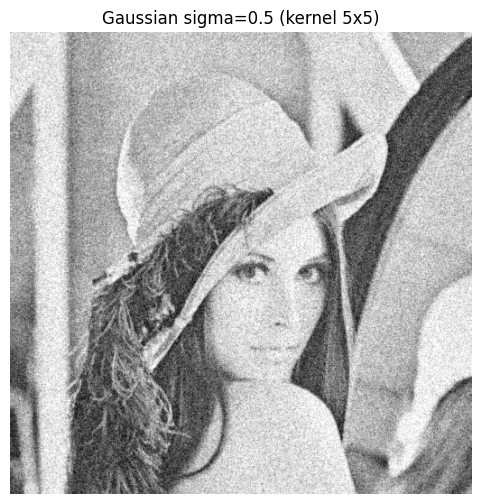

Gaussian sigma=1 (kernel 7x7): PSNR = 29.35


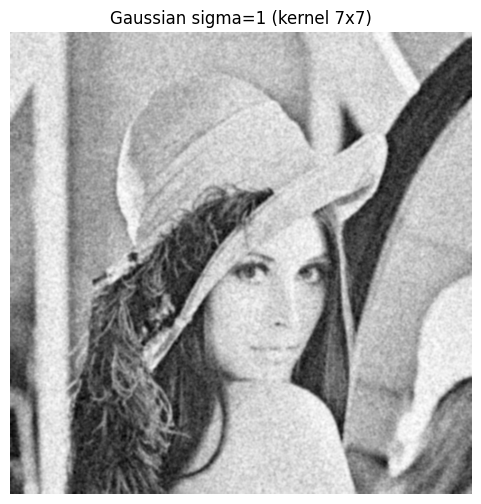

Gaussian sigma=2 (kernel 13x13): PSNR = 28.45


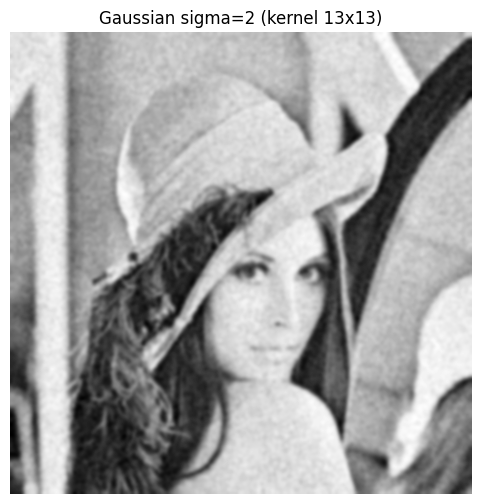

Median 3x3: PSNR = 26.95


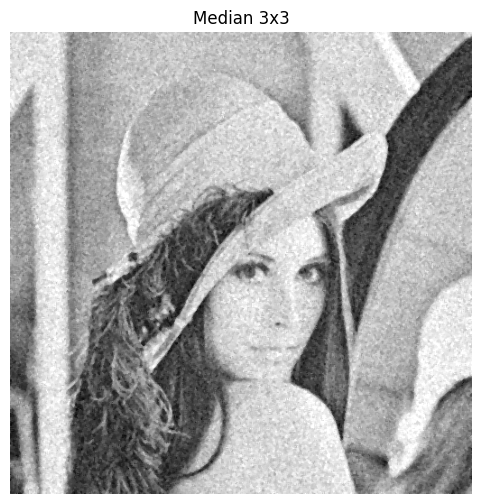

Median 5x5: PSNR = 28.61


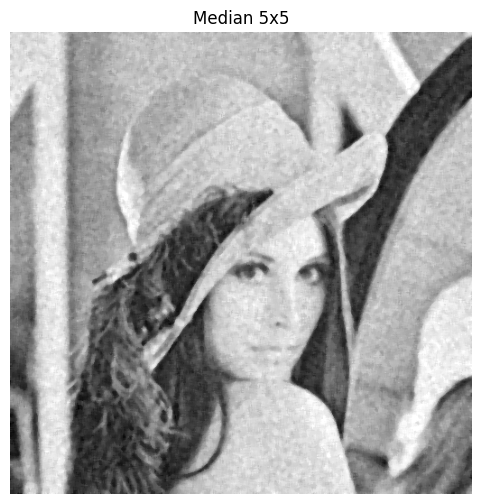

Median 9x9: PSNR = 27.44


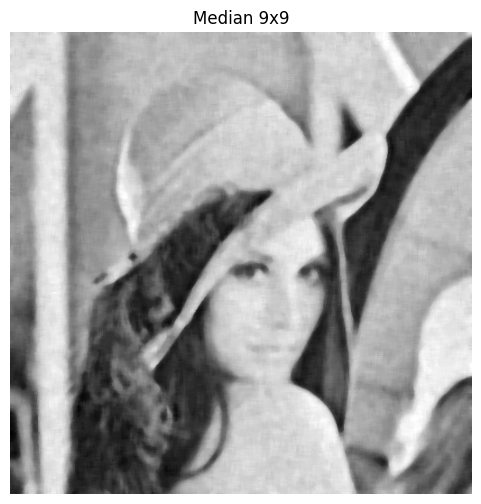

In [8]:
# Apply filters to Gaussian noisy image
filtered_results_gaussian = apply_filters(gaussian_noisy_image, sigma_values, median_sizes)

# Display results and calculate PSNR
print("PSNR for Gaussian Noise Filters:")
for filter_name, filtered_image in filtered_results_gaussian.items():
    psnr_value = psnr(image, filtered_image)
    print(f"{filter_name}: PSNR = {psnr_value:.2f}")
    plt.figure(figsize=(6, 6))
    plt.title(filter_name)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.show()

### b) Median filtering (Gaussian noise)

Do note that cv.medianBlur works only for uint8 image

In [9]:
def add_salt_and_pepper_noise(img, prob):
    noisy_img = img.copy()
    salt = np.random.rand(*img.shape) < prob / 2
    pepper = np.random.rand(*img.shape) < prob / 2
    noisy_img[salt] = 1
    noisy_img[pepper] = 0
    return noisy_img

# show results

### TODO: answer the questions

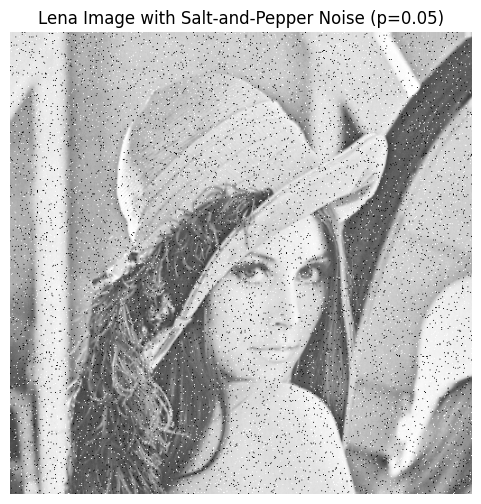

In [10]:
salt_pepper_noisy_image = add_salt_and_pepper_noise(image, prob=0.05)

# Display the noisy image
plt.figure(figsize=(6, 6))
plt.title("Lena Image with Salt-and-Pepper Noise (p=0.05)")
plt.imshow(salt_pepper_noisy_image, cmap='gray')
plt.axis('off')
plt.show()



### a) Gaussian filtering (Salt&Pepper noise)

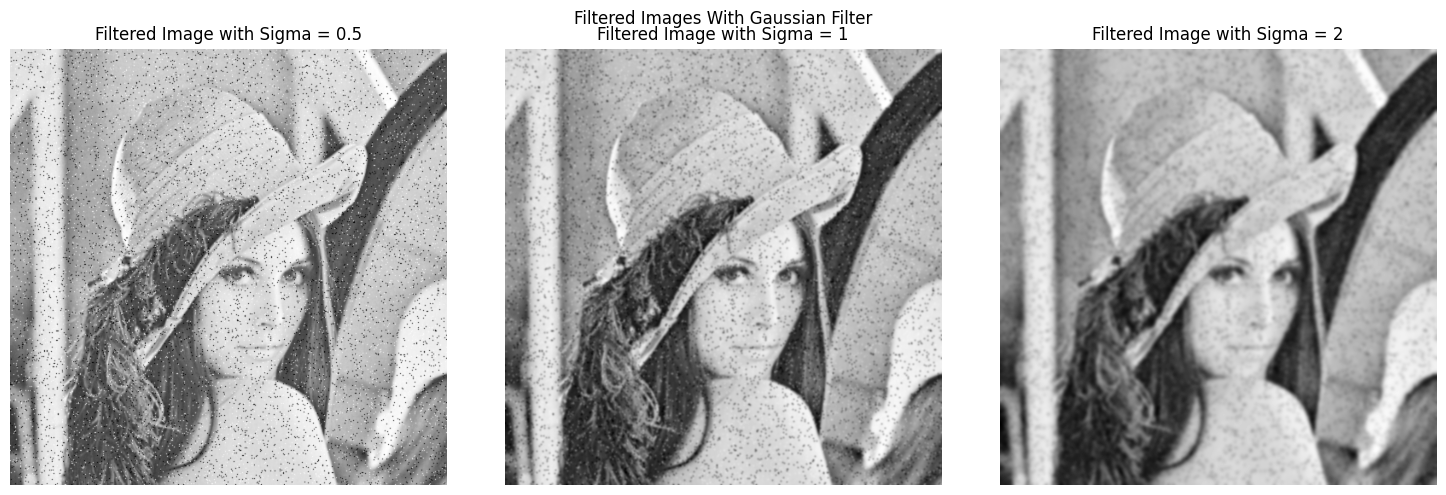

In [11]:
sp_gaussian_filtered_images = [gaussian_filter(salt_pepper_noisy_image, sigma=sigma) for sigma in sigma_values]
show_images(sp_gaussian_filtered_images,["Filtered Image with Sigma = 0.5", "Filtered Image with Sigma = 1","Filtered Image with Sigma = 2"],"Filtered Images With Gaussian Filter")

### b) Median filtering (Salt&Pepper noise)

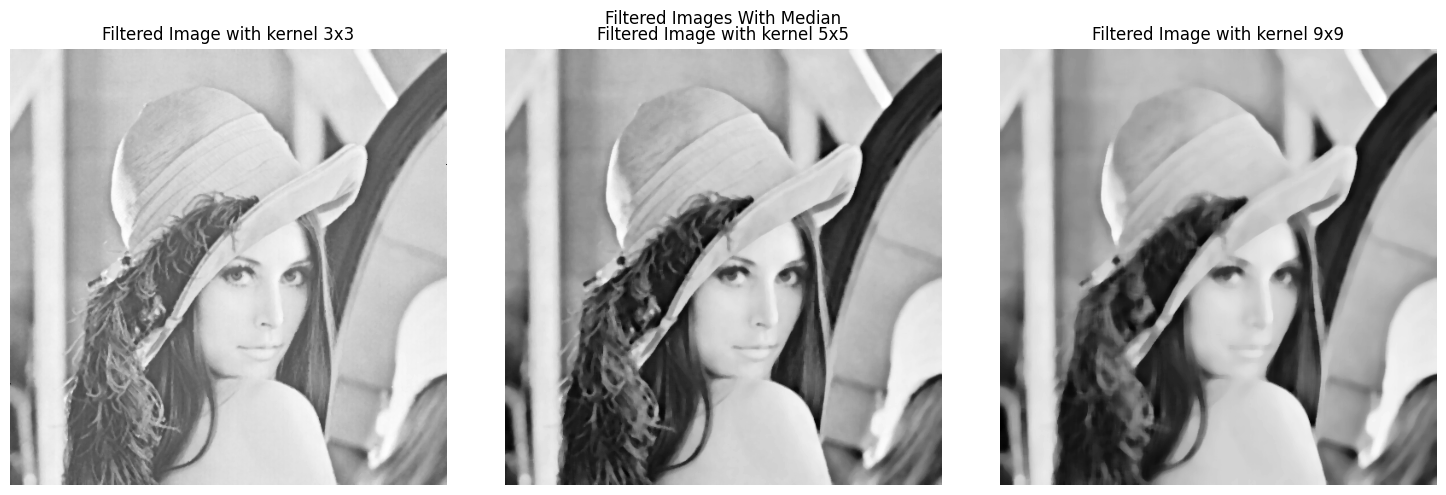

In [12]:
sp_median_filtered_images = [median_filter(salt_pepper_noisy_image, size=kernel) for kernel in median_sizes]
show_images(sp_median_filtered_images,["Filtered Image with kernel 3x3", "Filtered Image with kernel 5x5","Filtered Image with kernel 9x9"],"Filtered Images With Median")

### Comments

* Gaussian filtering is better for gaussian noise while median filtering is better for the salt and pepper noise.
* Kernel size parameter (sigma on salt and pepper noise) gives the  best filtering results as presents in the results from the codes.
* The higher PSNR the better results close to original image.
* median filtering keeps edges sharper while gaussian filtering smoothens them

## Task 3. Edge detectors (2 points)
You can install the `skimage` package by running `pip3 install scikit-image` 

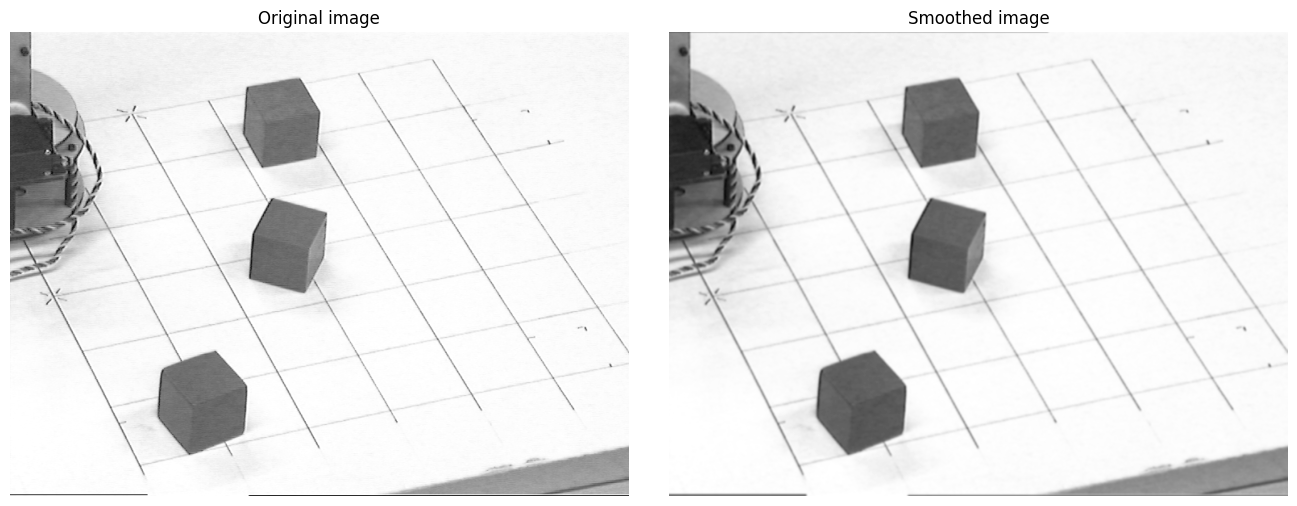

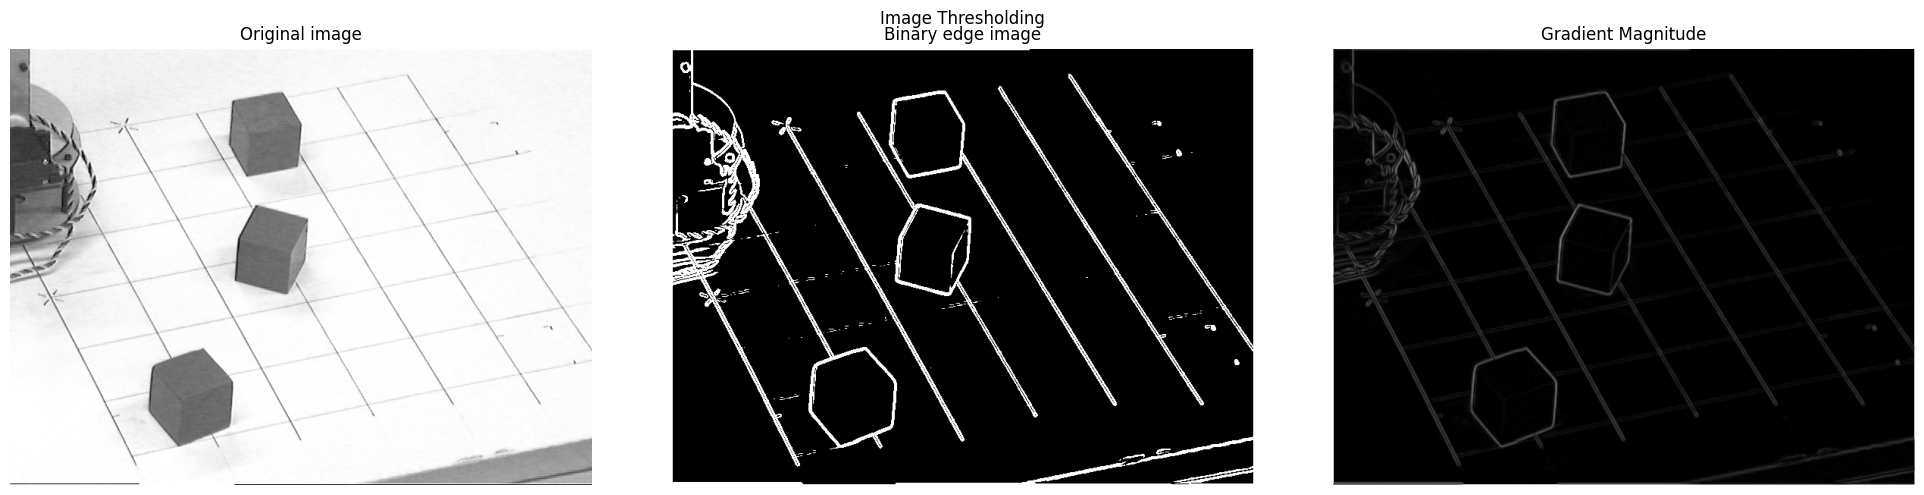

In [13]:
from skimage.morphology import skeletonize

# load image
image = cv2.imread('blocks_bw.png', cv2.IMREAD_GRAYSCALE)
image = image / 255.0

# apply Gaussian filter to smooth out the image
def apply_gaussian_filter(img, sigma):
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel size is odd
    smoothed = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)
    return smoothed

sigma = 1.0
smoothed_image = apply_gaussian_filter(image, sigma)

show_images([image,smoothed_image],["Original image", "Smoothed image"])

# find gradients (do NOT use ready made functions like cv.filter2D or cv.Sobel)
def apply_convolution(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    
    pad_height, pad_width = kernel_height // 2, kernel_width // 2
    
    # Pad the image with zeros
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 
                          mode='constant', constant_values=0)
    
    # Create an empty array to store the convolution results
    result = np.zeros_like(image)
    
    # Iterate through each pixel in the image
    for row in range(image_height):
        for col in range(image_width):
            region = padded_image[row:row + kernel_height, col:col + kernel_width]
            result[row, col] = np.sum(region * kernel)
    
    return result

# Define Sobel kernels for gradients
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [ 0,  0,  0], 
                    [ 1,  2,  1]])

# Compute gradients
Gx = apply_convolution(smoothed_image, sobel_x)
Gy = apply_convolution(smoothed_image, sobel_y)

# threshold image
# Computing gradient magnitude and threshold it
def threshold_gradient(Gx, Gy, threshold):
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    binary_image = gradient_magnitude > threshold
    return binary_image

threshold = 0.3  
binary_edge_image = threshold_gradient(Gx, Gy, threshold)
grad_mag = np.sqrt(Gx**2 + Gy**2)
show_images([image,binary_edge_image,grad_mag],["Original image", "Binary edge image","Gradient Magnitude"],"Image Thresholding")

# thin the image using "skeletonize"
thinned_image = skeletonize(binary_edge_image)

### TODO: answer the question

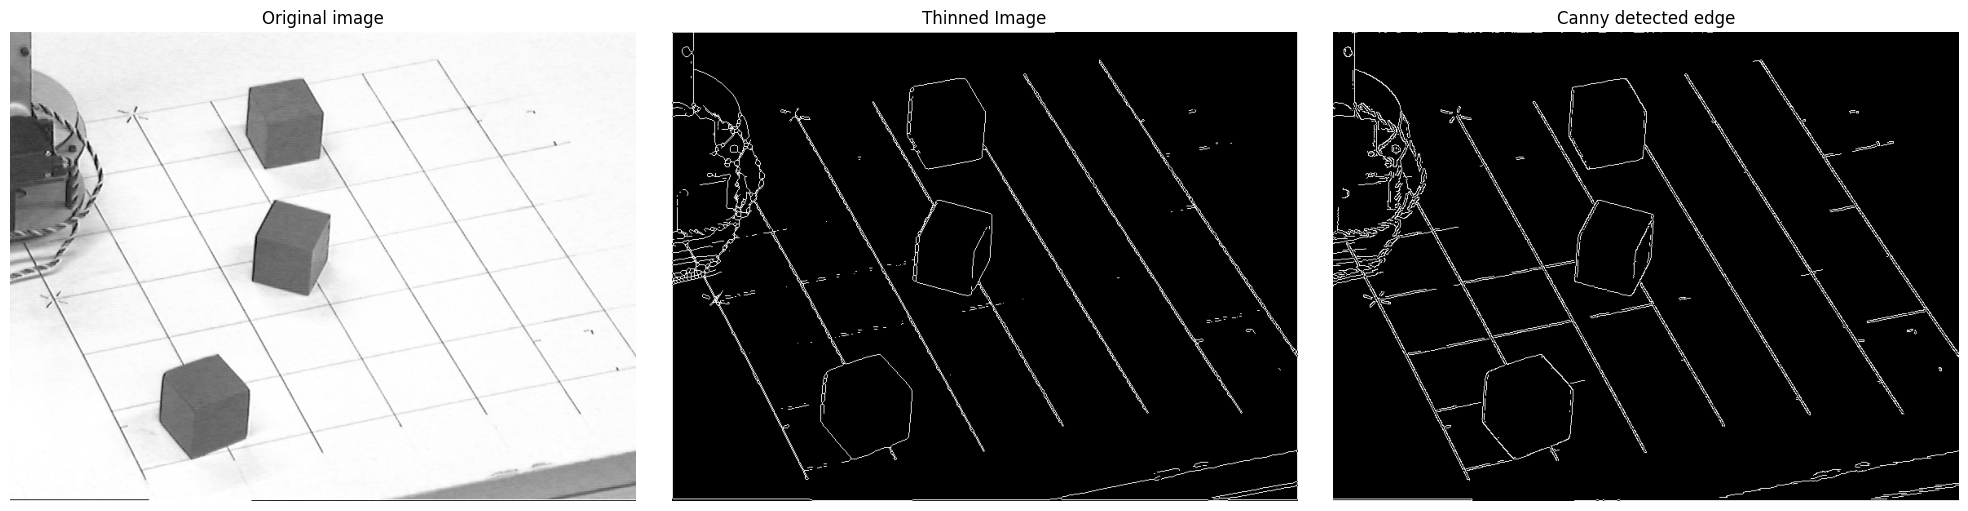

In [14]:
canny_edges = cv2.Canny((image*255).astype(np.uint8), 100, 200) 

# show result
show_images([image,thinned_image,canny_edges],["Original image", "Thinned Image", "Canny detected edge"])

### Comments
* The binary edge image edges are very shap but all the details.
* Gradient magnitude shows blury edges but it shows most of the details both in horizontal direction and vertical direction.
* Thinned image is much like binary image with sharp edges.
* Canny edged images are sharp and try to conserve both vertical and horizontal components.

### Without a) and c)

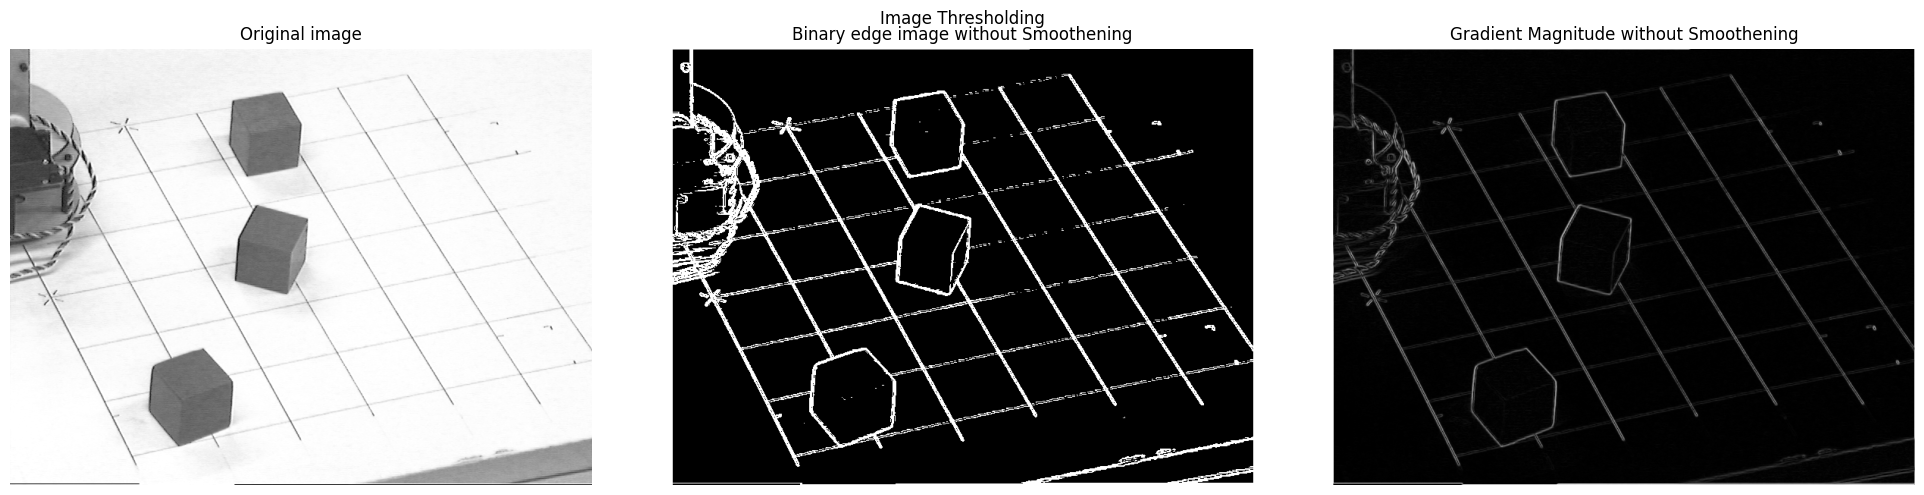

In [15]:
Gx = apply_convolution(image, sobel_x)
Gy = apply_convolution(image, sobel_y)
binary_edge = threshold_gradient(Gx, Gy, threshold)
raw_grad_mag = np.sqrt(Gx**2 + Gy**2)
show_images([image,binary_edge,raw_grad_mag],["Original image", "Binary edge image without Smoothening","Gradient Magnitude without Smoothening"],"Image Thresholding")

### comments

* Without smoothing, the edges are clearly shown in all directions
* All the details are clear 
* Also the noise is taken into account.

Overall, I think depending on your goal, you might smoothen image or not.